In [212]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
train  = pd.read_csv(r'''D:\CHIRAG\Analytics Vidhya Hackathon\Twitter Sentiment Analysis\train_E6oV3lV.csv''')
test = pd.read_csv(r'''D:\CHIRAG\Analytics Vidhya Hackathon\Twitter Sentiment Analysis\test_tweets_anuFYb8.csv''')
train.sample(2)

,id,label,tweet
9913,9914,0,#marathon bull up: you will dominate your bu...
29097,29098,0,if the gorgeous day isn't resonating on the in...


In [3]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [4]:
df = train.append(test, ignore_index = True)
df.shape

(49159, 3)

Remove twitter handlers i.e., @user

In [5]:
train['cleaned_tweet'] = train.tweet.apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))
test['cleaned_tweet'] = test.tweet.apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))

### Hashtags

In [26]:
#Select all words from normal tweet
normal_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 0]])
#Collect all hashtags
pos_htag = [htag for htag in normal_words.split() if htag.startswith('#')]
#Remove hashtag symbol (#)
pos_htag = [pos_htag[i][1:] for i in range(len(pos_htag))]
#Count frequency of each word
pos_htag_freqcount = nltk.FreqDist(pos_htag)
pos_htag_df = pd.DataFrame({'Hashtag' : list(pos_htag_freqcount.keys()),
                            'Count' : list(pos_htag_freqcount.values())})

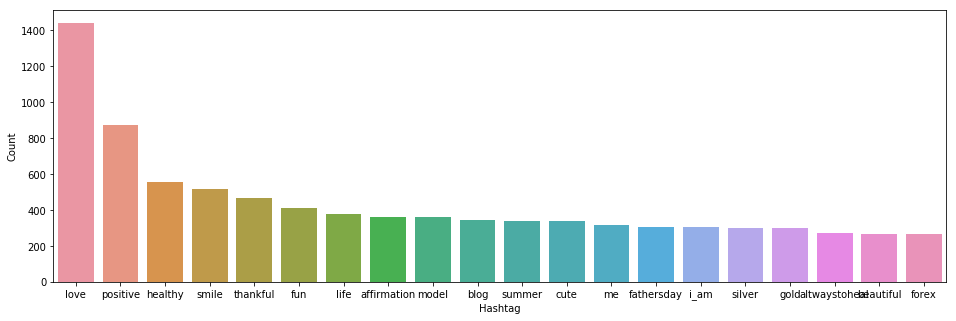

In [27]:
#Select top 20 most frequent hashtags and plot them   
most_frequent = pos_htag_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=most_frequent, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [28]:
#Repeat same steps for negative tweets
negative_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 1]])
neg_htag = [htag for htag in negative_words.split() if htag.startswith('#')]
neg_htag = [neg_htag[i][1:] for i in range(len(neg_htag))]
neg_htag_freqcount = nltk.FreqDist(neg_htag)
neg_htag_df = pd.DataFrame({'Hashtag' : list(neg_htag_freqcount.keys()),
                            'Count' : list(neg_htag_freqcount.values())})

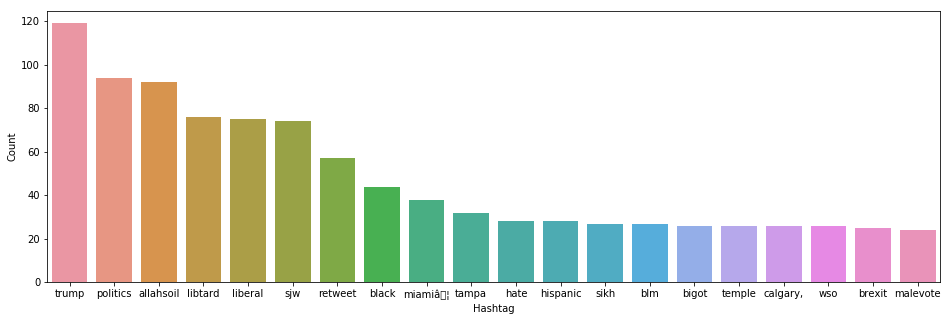

In [40]:
most_frequent = neg_htag_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=most_frequent, x= "Hashtag", y = "Count")
plt.show()

From both plots, we can conclude that hashtags are very important for sentiment analysis and should not be ignored.

## Finding common words in both classes of tweets using Visualization

### Normal Tweets

Normal words


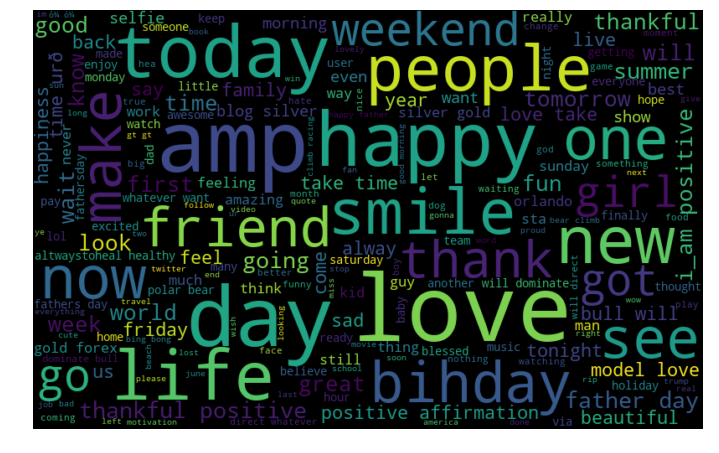

In [41]:
normal_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Racist/Sexist Tweets

Negative words


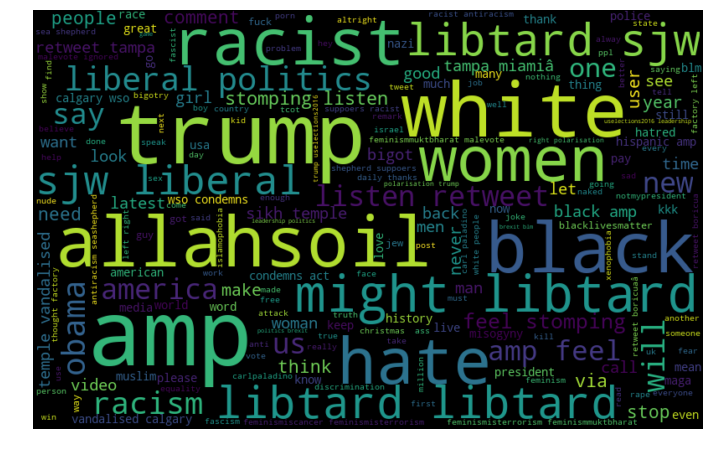

In [42]:
negative_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110).generate(negative_words)
print('Negative words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Words used like love, friend, happy are used in normal tweets whereas racist/sexist can be found in words like trump, black, politics etc.

In [44]:
train.sample(2)

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...


In [66]:
X_train, X_val, y_train, y_val = train_test_split(train['cleaned_tweet'], train['label'], random_state = 0)
X_train.shape, X_val.shape

((23971,), (7991,))

## Applying Bag-of-Words

Rescale data using CountVectorizer
### CountVectorizer

In [220]:
vect = CountVectorizer().fit(X_train)
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [221]:
print('Total features =', len(vect.get_feature_names()))
print(vect.get_feature_names()[::5000])

Total features = 34478
['00', 'btg', 'encouragement', 'ifcarlingdidperfectdays', 'mona', 'rdoequipment', 'technology']


In [222]:
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<23971x34478 sparse matrix of type '<class 'numpy.int64'>'
	with 266363 stored elements in Compressed Sparse Row format>

### Naive Bayes

In [107]:
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1 :', f1_score(y_val, pred))

F1 : 0.5725288831835686


### Logistic Regression

In [224]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1 :', f1_score(y_val, pred))

F1 : 0.6473317865429236


Logistic Regression performed well then Naive Bayes for the default parameters. Thus, we will be using only Logistic Regression ahead.

Lets now rescale the data using tf-idf

### Tfidf

In [72]:
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer().fit(X_train)
print('Total Features =', len(vect.get_feature_names()))
X_train_vectorized = vect.transform(X_train)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1: ', f1_score(y_val, pred))

Total Features = 34478
F1:  0.41907514450867056


tf-idf not performed well for this data.

## Bag-of-Words with more than one word (n-grams)

### min_df & n-grams

In [211]:
vect = CountVectorizer(min_df = 2, ngram_range = (1,2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
print('Total Features =', len(vect.get_feature_names()))

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1: ', f1_score(y_val, pred))

Total Features = 38957
F1:  0.6447831184056272


### Hyper parameter tuning

In [218]:
pipe = make_pipeline(CountVectorizer(), LogisticRegression())
param_grid = {"logisticregression__C": [0.01, 0.1, 1, 10, 50, 100],
              "countvectorizer__min_df": [1,2,3],
              "countvectorizer__ngram_range": [(1,1), (1,2), (1,3)]}
grid = GridSearchCV(pipe, param_grid, cv = 5, scoring = 'f1', n_jobs = -1)
grid.fit(X_train, y_train)
print('Best parameters:', grid.best_params_)

Best parameters: {'countvectorizer__min_df': 1, 'countvectorizer__ngram_range': (1, 1), 'logisticregression__C': 10}


OOPS!!! For this dataset, our default parameters were the best except fot our model (C = 10)

In [225]:
vect = CountVectorizer(min_df = 1, ngram_range = (1,1)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
print('Total Features =', len(vect.get_feature_names()))

model = LogisticRegression(C = 10)
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1: ', f1_score(y_val, pred))

Total Features = 34478
F1:  0.681917211328976


In [226]:
print('Fraction of racist/sexist tweet in train data :', train.label.sum()/len(train))
print('Fraction of racist/sexist tweet predicted by model :', pred.sum()/len(pred))

Fraction of racist/sexist tweet in train data : 0.07014579813528565
Fraction of racist/sexist tweet predicted by model : 0.04842948316856464


Fraction is very less. Lets change the default predict probability.

In [240]:
pred_prob = model.predict_proba(vect.transform(X_val))
pred = np.where(pred_prob[:,1] > 0.35, 1, 0)
print('Fraction of racist/sexist tweet predicted by model :', sum(pred)/len(pred))
print('F1: ', f1_score(y_val, pred))

Fraction of racist/sexist tweet predicted by model : 0.055437367037917656
F1:  0.6960985626283367


Using hyperparameter tuning and probability method, we were able to improve our model score by 5%.

Lets look at largest and smallest coefficients that our model used.

In [210]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()
print('Smallest_coefs :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest_coefs :\n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest_coefs :
['hardcore' 'bihday' 'orlando' 'day' 'healthy' 'fathersday' 'smile' 'epic'
 'miscegenation' 'sad']

Largest_coefs :
['allahsoil' 'arabs' 'bigot' 'racism' 'blacklivesmatter' 'malevote'
 'iconic' 'watch this' '2017' 'fakenews']


The smallest coefficients are indicating to normal tweets to the model whereas the largest coeeficients are indicative for racist/sexist tweets.

In [243]:
X_test = test['tweet']
test_pred = model.predict_proba(vect.transform(X_test))
predictions = np.where(test_pred[:,1] > 0.35, 1, 0)
results = pd.DataFrame(data = {'id' : test.id, 'label' : predictions})
results.to_csv('results.csv', index = False)